# Hybrid Word Sense Disambiguation

Hybrid WSD relies both on knowledge-based and corpus-based information.

For example, one can apply a supervised method but select features based on WordNet relations.
It was also shown that filtering features in a supervised model based on syntactic relations to the target word can have positive effects on performance: https://aclanthology.org/W13-3825.pdf


# Unsupervised Word Sense Disambiguation

## Expectation Maximization

For the unsupervised case, the optimization problem can be solved only by
iterative methods. The Expectation-Maximization algorithm
is a very successful iterative method, known as very well fitted for models with
missing data.
Each iteration of the algorithm involves two steps:

• estimation of the missing data by the conditional expectation method (**E-step**)

• estimation of the parameters by maximization of the likelihood function for complete data (**M-step**)

The E-step calculates the conditional expectations given the current parameter
values, and the M-step produces new, more precise parameter values.


(See pdf for computation details)

In [1]:
# Implementations of EM in python:

from nltk.cluster import EMClusterer

## Ant Colony

### Global WSD

It was developped by Didier Schwab, Jérôme Goulian, Andon Tchechmedjiev, Hervé Blanchon in their article Ant Colony Algorithm in [Unsupervised Word Sense Disambiguation of Texts: Comparison and Evaluation](https://www.researchgate.net/publication/235344265_Ant_Colony_Algorithm_for_the_Unsupervised_Word_Sense_Disambiguation_of_Texts_Comparison_and_Evaluation).

- Ant colony algorithm is based on the way ants search for food.
- It is a global word sense disambiguation algorithm. It is unsuppervised, meaning it needs no tagged corpora to train.
- it is an incomplete approach - it doesn't go through the entire solution space, it tries to obtain a local maximum
- The context window for the analysis will be the whole text.
- It uses a modified extended Lesk measure


Ant colony algorithms are part of the swarm intelligence algorithms category.

The problem is usually represented as a graph, and the ants walk through this graph in search for food and back to their nests. The graph has two types of nodes:

- common nodes
- nests

The nests are ants generators. The ants start searching for energy (food) throughout the graph. The number of ants produced by the nest depends on how much energy the nest has (if it has more energy, brought by the ants, it can produce more ants).

When ants walk on an edge they leave an odour tray corresponding to their mother nest. The odour will help other to adjust their routes.

An ant sees the nodes in the algorithm in three possible ways:

- mother nest (where it was produced)
- enemy nest (rivals to the mother nest)
- potential friend nest (the rest of the nests)

Ants choose to follow a certain edge depending on the found pheromone on the edge, on the odour of other nodes and on the energy

Ants can create bridges (new edges) between nests based on a computed score between them. However, these bridges disappear if they reach 0 pheromone.

#### Implementation steps

We will use the same notations that were used in the article:

Notation	Meaning
- wi :	a word (i is an index)
- wi,j :	a sense j for the word i
- d(wi,j) :	the definition for the sense j of the word i
- C :	a configuration of senses (a potential solution) organized as a list of senses corresponding to each word from the text

1. Create a function that computes the relatedness between two senses, based on the Extended Lesk measure, but with the following modification: you will not take into consideration the postion of the words (we don't compute the common substrings, just the number of common words, like in the original Lesk algorithm). Stop words must be eliminated from the definition. You consider the whole definition text as a bag of words. To compute this measure (and also to use the definitions further in the algorithm) we assign a number (like an id) to each definition word (from all the definitions) and we sort the resulting set of numbers. For example, for the definition:

In [46]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [47]:
from nltk.corpus import wordnet
wordnet.synset('flower.n.01').definition()

'a plant cultivated for its blooms or blossoms'

In [48]:
from nltk.corpus import stopwords
l = wordnet.synset('flower.n.01').definition().split(' ')
l

['a', 'plant', 'cultivated', 'for', 'its', 'blooms', 'or', 'blossoms']

In [49]:
[x for x in l if x not in stopwords.words('english')]

['plant', 'cultivated', 'blooms', 'blossoms']

Let's imagine that we have the following assignments:
- plant - 7
- cultivated - 1
- blooms - 55
- blossoms - 23

The resulting set of ids, after the processing would be: [1, 7, 23, 55]


2. We create a fitness function that computes the score for a configuration (a list of assigned senses for the words in the text):


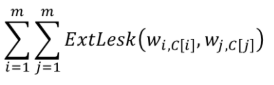

C[k] is the assigned sense for the word in k-th position in the text


3. We create the corresponding problem graph:


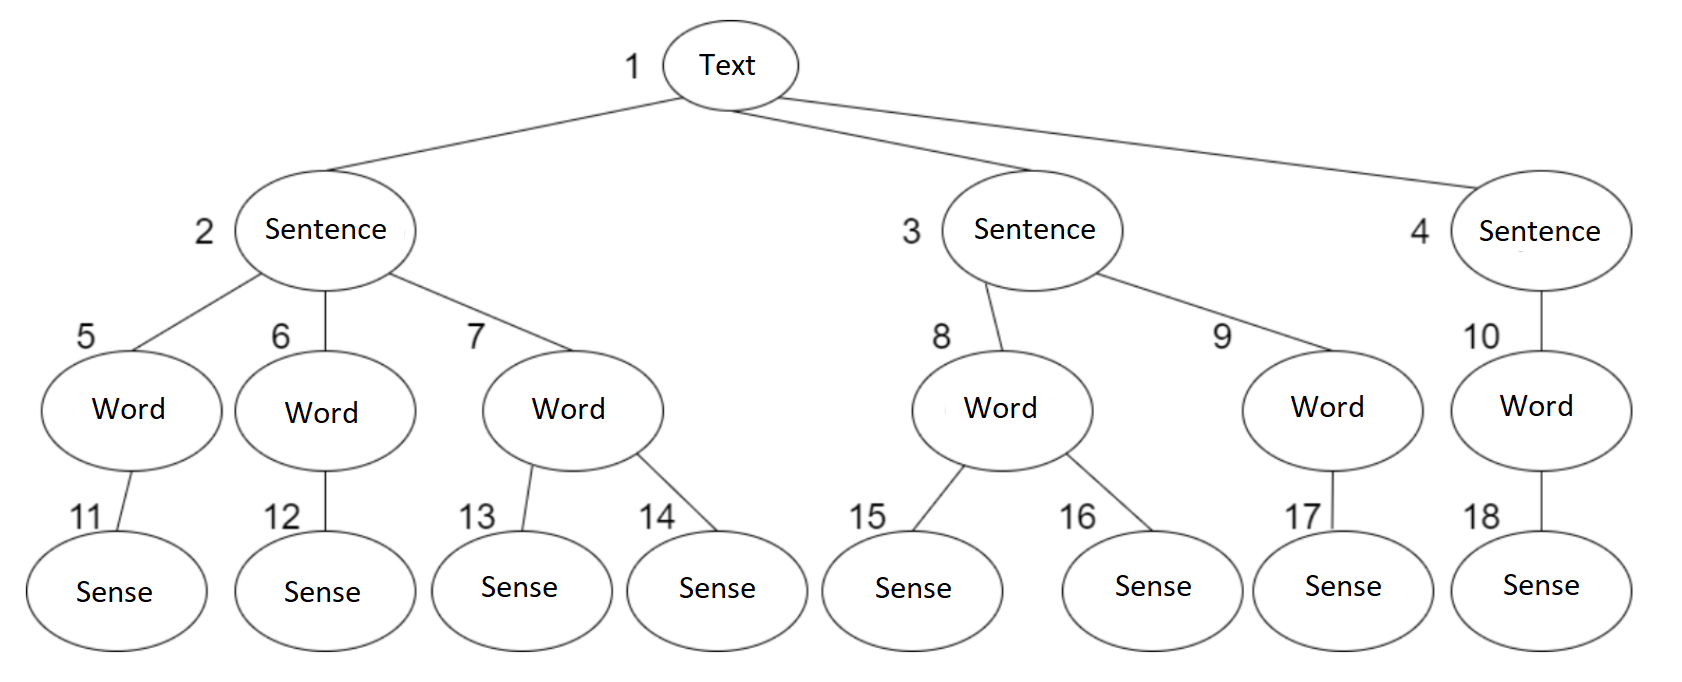

The word senses are the nests, and the rest of the nodes are common nodes. Each node has assigned an initial energy (in the article they used values between 5-60)
4. We assign the initial odour to the nodes in the graph. The odour will be represented by an array of a fixed length (in the article they used a length between 20-200). The nests have the words in the definition in their odour array. Common nodes have (initially) null values in their odour array.

5. The algorithm will run on a certain number of cycles (the maximum number of cycles used in the algorithm was 500) that contain three actions:

  1. clean the graph by removing the dead ants (ants have a lifespan of ω cycles; in the article they set ω to a fixed number between 1-30;). The energy that was carried by the ant is added to the energy of the node where it died. We also remove the bridges with zero pheromone
  2. produce new ants. The ants are produced with a certain probability computed through this formula:

    `arctan(E(N))/π+0.5`, where E(N) is the energy in the nest node N.

  3. move the ants in the graph and create bridges if the move requires so. The ant when searching for energy chooses an edge to move with the following probability:

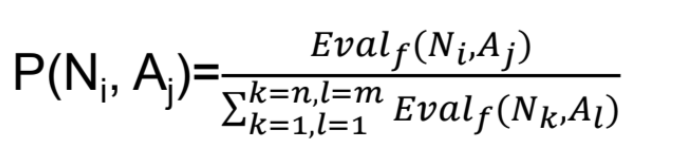

Evalf(N,A)=Evalf(N)+Evalf(A)

Evalf(A) = 1 − φt(A)

φt(A)= quantity of pheromone on edge A

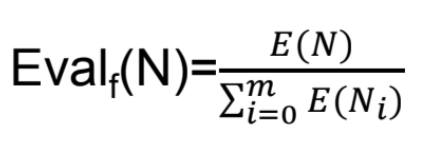

An ant decides to return with the probability E(f)/Emax It uses the same probability Evalf(N,A) with Evalf(A) = φt(A)
and

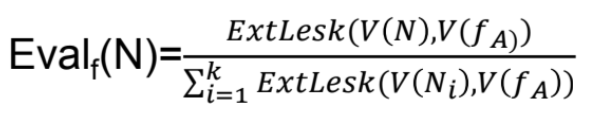

When creating a bridge, we have Evalf(A)=0

  4. compute the new energy and odour for the nodes, and the pheromone on the edges. For each passing an ant deposits some pheromone on that edge(new_pheromone =old_pheromone+θ). Also we have an evaporation rate, 𝛿 (on an edge new_pheromone= old_pheromone*(1-𝛿). An ant randomly gives parts of its odour to the node it travels through.


6. we choose the senses corresponding to the nest with the highest amount of energy

Observation: Bridges between unrelated senses will disappear in time (because the pheromone is dissipated in time), however, bridges between related senses will thrive.


# Exercises (1p / deadline 02.06)

1. Implement a feature extraction function for the Naive Bayes supervised model to be used in a hybrid disambiguation model: only selects context words with certain dependency relations to the target word. You can assume the target word is a noun. The types of dependencies will be given as arguments - run an example calling the feature extraction function on a sample of 50 sentences from the Senseval corpus where the target word is `line` the dependecy types considered are `[amod]`.

In [3]:
!wget 'https://nlp.stanford.edu/software/stanford-corenlp-latest.zip'
!unzip 'stanford-corenlp-latest.zip'

--2022-06-02 15:42:40--  https://nlp.stanford.edu/software/stanford-corenlp-latest.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-latest.zip [following]
--2022-06-02 15:42:40--  https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-latest.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 505207915 (482M) [application/zip]
Saving to: ‘stanford-corenlp-latest.zip’

stanford-corenlp-la 100%[===================>] 481.80M  5.07MB/s    in 92s     

2022-06-02 15:44:13 (5.22 MB/s) - ‘stanford-corenlp-latest.zip’ saved [505207915/505207915]

Archive:  stanford-corenlp-latest.

In [6]:
!pip install stanfordcorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import stanfordcorenlp
sc = stanfordcorenlp.StanfordCoreNLP('/content/stanford-corenlp-4.4.0')

In [9]:
text = "There is nothing wrong with it."
dependencies = sc.dependency_parse(text)
dependencies

[('ROOT', 0, 2),
 ('expl', 2, 1),
 ('nsubj', 2, 3),
 ('amod', 3, 4),
 ('case', 6, 5),
 ('obl', 2, 6),
 ('punct', 2, 7)]

In [10]:
import nltk
nltk.download('senseval')
from nltk.corpus import senseval

[nltk_data] Downloading package senseval to /root/nltk_data...
[nltk_data]   Package senseval is already up-to-date!


In [13]:
target_word = 'line'
instances_line = senseval.instances(target_word +'.pos')
instances_line[3]

SensevalInstance(word='line-n', position=20, context=[('there', 'EX'), ('is', 'VBZ'), ('nothing', 'NN'), ('easy', 'JJ'), ('about', 'IN'), ('running', 'VBG'), ('a', 'DT'), ('cruise', 'NN'), ('boat', 'NN'), ('in', 'IN'), ('winter', 'NN'), ('.', '.'), ('it', 'PRP'), ('takes', 'VBZ'), ('boiling', 'VBG'), ('water', 'NN'), ('to', 'TO'), ('thaw', 'VB'), ('the', 'DT'), ('frozen', 'VBN'), ('lines', 'NNS'), ('at', 'IN'), ('the', 'DT'), ('clinton', 'NNP'), ("'s", 'POS'), ('overnight', 'JJ'), ('berth', 'NN'), ('so', 'RB'), ('that', 'IN'), ('the', 'DT'), ('boat', 'NN'), ('can', 'MD'), ('be', 'VB'), ('brought', 'VBN'), ('around', 'IN'), ('to', 'TO'), ('the', 'DT'), ('passenger', 'NN'), ('pier', 'NN'), ('.', '.')], senses=('cord',))

In [44]:
def extract_features(instances, num_samples=250):
  """
    selects context words with [amod] dependency relation to the target word
  """
  context_words = []
  for instance in instances[:num_samples]:
    p = instance.position
    text = ' '.join(w for (w, t) in instance.context)

    dependencies = sc.dependency_parse(text)
    for dependency in dependencies:
      if dependency[0] == 'amod':
        if dependency[1] == p:
          context_words.append(instance.context[dependency[2]][0])
        elif dependency[2] == p:
          context_words.append(instance.context[dependency[1]][0])
  
  return context_words

In [45]:
print(extract_features(instances_line))

[',', 'with', 'at', 'fishermen', 'on', '.', 'to', 'the']


2. Implement the modified Extended Lesk similarity measure which optimizes the complexity of the computation by using a cached vector of overlaps between two definitions, where each position in the vector corresponds to a word. The output will be a vector containing the amount of overlap between two senses for each word in the vocabulary.

a. For the words `line` and `interest`, select all their WordNet synsets and corresponding definitions, and build an index of all words occuring in their definitions. Stopwords are ignored.

e.g. `vocabulary = {1: word1, 2: word2, ...}`

In [67]:
import string

from nltk import download
download('wordnet')
nltk.download('punkt')

from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
line_synsets = wn.synsets('line')
interest_synsets = wn.synsets('interest')

words_definitions = []

for line_synset in line_synsets:
  line_def = line_synset.definition()
  words_def = nltk.word_tokenize(line_def)
  words = [word for word in words_def if word not in stopwords.words('english') + list(string.punctuation)]
  words_definitions += words

for interest_synset in interest_synsets:
  interest_def = interest_synset.definition()
  words_def = nltk.word_tokenize(interest_def)
  words = [word for word in words_def if word not in stopwords.words('english') + list(string.punctuation)]
  words_definitions += words

vocabulary = {}
words_definitions = set(words_definitions)
for word in words_definitions:
  if word not in vocabulary.keys():
    vocabulary[word] = len(vocabulary)

vocabulary

{"'s": 193,
 '1/14': 199,
 'access': 63,
 'across': 179,
 'acting': 52,
 'actions': 130,
 'activity': 147,
 'advertising': 19,
 'aimed': 92,
 'aims': 34,
 'allowed': 64,
 'along': 119,
 'amount': 164,
 'another': 58,
 'area': 38,
 'article': 206,
 'attention': 181,
 'attracting': 112,
 'band': 133,
 'behind': 67,
 'beside': 40,
 'borrowed': 211,
 'borrowing': 185,
 'bounds': 121,
 'breadth': 18,
 'carrier': 72,
 'charge': 6,
 'column': 23,
 'commercial': 168,
 'common': 69,
 'communication': 33,
 'computer': 41,
 'conceptual': 165,
 'concern': 138,
 'conductor': 14,
 'conformity': 190,
 'connected': 188,
 'connection': 107,
 'consequence': 88,
 'consisting': 43,
 'control': 28,
 'conveyed': 0,
 'cord': 136,
 'course': 46,
 'cover': 65,
 'credit': 197,
 'curiosity': 48,
 'curved': 37,
 'customer': 97,
 'deceive': 90,
 'deep': 32,
 'defined': 184,
 'demonstrating': 17,
 'depression': 156,
 'descendants': 2,
 'developments': 98,
 'distinction': 175,
 'distinctive': 102,
 'diversion': 82,


b. Given a sentence as a string, write a function that computes its representation as a vector of indices corresponding to the sorted indices in the vocabulary of words in the definition.

e.g. returned representation: [1, 7, 23, 55] (see above)

In [72]:
def definition_vector(definition_sentence):
  words_sentence = nltk.word_tokenize(definition_sentence)
  words_sentence = [word for word in words_sentence if word not in stopwords.words('english') + list(string.punctuation)]
  return [vocabulary.get(word, -1) for word in words_sentence]

In [78]:
definition_vector(wn.synsets('line')[0].definition())

[49, 111, 131, 176, 40, 58]

c. Given a WordNet sense of the word `line` and a WordNet sense of the word `interest` (as their index in the list of WordNet Synsets), compute the extended Lesk score between the two senses returning a vector of overlaps corresponding to each word in the created vocabulary. 

In [118]:
def extended_lesk_optimized(line_sense_index, interest_sense_index):
  line_sense = wn.synsets('line')[line_sense_index].definition()
  line_vector = definition_vector(line_sense)

  interest_sense = wn.synsets('interest')[interest_sense_index].definition()
  interest_vector = definition_vector(interest_sense)
  
  overlaps = [0] * len(vocabulary)
  for w_idx1 in line_vector:
    if w_idx1 in interest_vector:
      overlaps[w_idx1] = interest_vector.count(w_idx1)

  return overlaps

In [119]:
extended_lesk_optimized(0, 2)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

e.g. return value: `[1 0 13 2 9]` where 13 corresponds to overlap for word with index 3 in the vocabulary, 9 corresponds to overlap for word with index 5 in the vocabulary etc.